### This Workbook will prepare the data set and develop relevant statistics (mean, standard deviation, covariance etc.)  

#### Import Libraries

In [1]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd

import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline
import seaborn as sns # Plotting

import datetime as dt # For defining dates
import mplfinance as mpf # Matplotlib finance
import time

# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

#### Constants

May or may not be used. Purpose of this Workbook is to create required as well as optional tools.

In [14]:
# define folder containing historical share prices data 
PATH = (r"C:/Users/User/Documents/PM Tools/US Share Market Data/Wilshire5000/") 
t_days = 252 # average number of trading days in a year

S_YEAR = 2013
S_MONTH = 1
S_DAY = 1
S_DATE_STR = f"{S_YEAR}-{S_MONTH}-{S_DAY}" #string representation of start date
S_DATE_DATETIME = dt.datetime(S_YEAR, S_MONTH, S_DAY) #datetime object representation of start date

E_YEAR = 2022
E_MONTH = 12
E_DAY = 31
E_DATE_STR = f"{E_YEAR}-{E_MONTH}-{E_DAY}" #string representation of end date
E_DATE_DATETIME = dt.datetime(E_YEAR, E_MONTH, E_DAY) #datetime object representation of end date

#### Get Share Ticker Names and place in List

In [15]:
files = [x for x in listdir(PATH) if isfile(join(PATH, x))]  
# listdir retuns all files in a directory (PATH). 
# isfile returns TRUE if file, and store in list []
tickers = [os.path.splitext(x)[0] for x in files] 
# splitext splits the path name into a pair root and ext.; ticker name and extension(.csv). 
# Index [0] points to root.
# Get all file names and store in "tickers".
tickers


['A',
 'AA',
 'AAC',
 'AAL',
 'AAME',
 'AAN',
 'AAOI',
 'AAON',
 'AAP',
 'AAPL',
 'AAT',
 'AAWW',
 'ABBV',
 'ABC',
 'ABCB',
 'ABEO',
 'ABG',
 'ABIO',
 'ABM',
 'ABMD',
 'ABR',
 'ABT',
 'ABTX',
 'AC',
 'ACA',
 'ACAD',
 'ACBI',
 'ACC',
 'ACCO',
 'ACER',
 'ACGL',
 'ACHC',
 'ACHN',
 'ACHV',
 'ACIA',
 'ACIW',
 'ACLS',
 'ACM',
 'ACMR',
 'ACN',
 'ACNB',
 'ACOR',
 'ACRE',
 'ACRS',
 'ACRX',
 'ACTG',
 'ACU',
 'ADBE',
 'ADC',
 'ADES',
 'ADI',
 'ADM',
 'ADMA',
 'ADMP',
 'ADMS',
 'ADNT',
 'ADP',
 'ADSK',
 'ADT',
 'ADTN',
 'ADUS',
 'ADVM',
 'ADXS',
 'AE',
 'AEE',
 'AEGN',
 'AEHR',
 'AEIS',
 'AEL',
 'AEMD',
 'AEO',
 'AEP',
 'AERI',
 'AES',
 'AEY',
 'AFG',
 'AFL',
 'AGCO',
 'AGE',
 'AGEN',
 'AGFS',
 'AGIO',
 'AGLE',
 'AGM',
 'AGNC',
 'AGO',
 'AGR',
 'AGRX',
 'AGS',
 'AGTC',
 'AGX',
 'AGYS',
 'AHH',
 'AHT',
 'AIG',
 'AIMC',
 'AIMT',
 'AIN',
 'AINC',
 'AIR',
 'AIRG',
 'AIRI',
 'AIRT',
 'AIT',
 'AIV',
 'AIZ',
 'AJG',
 'AJRD',
 'AJX',
 'AKAM',
 'AKBA',
 'AKCA',
 'AKR',
 'AKTS',
 'AL',
 'ALB',
 'ALBO',
 'AL

In [16]:
# number of tickers
len(tickers) 

3127

#### Return Dataframe from CSV

In [17]:
def get_df_from_csv(ticker):
    try:
        df = pd.read_csv(PATH + ticker + '.csv')
    except FileNotFoundError:
        print("File Doesn't Exist")
    else:
        return df

#### Save Dataframe to CSV

In [18]:
def save_df_to_csv(df, ticker):
    df.to_csv(PATH + ticker + ".csv")

#### Return First Valid Dates in Dataframe
In some instances data for required start and end dates may not be available or is presented in incorrect format. Function bellow returns first available valid dates for the required date range.

In [19]:
def get_valid_dates(df, sdate, edate):
    try:
        mask = (df['date'] > sdate) & (df['date'] <= edate) # mask of / select the required date range
        df2 = df.loc[mask] # select only those dates defined by mask 
        df2 = df2.set_index(['date']) #set index to dates for use in upcoming functions
    
        # get first and last dates that match
        first_date = df2.index.min()
        last_date = df2.index.max()
    
        # add leading zeros to date:
        # cycle through all dates separated by dashes (-).
        # split string on (-). If lenght of a number is less than 2, add a zero up front (Ex: 2000-01-12 instead of 2000-1-12).
        date_leading = '-'.join(('0' if len(x)<2 else '')+x for x in first_date.split('-'))
        date_ending = '-'.join(('0' if len(x)<2 else '')+x for x in last_date.split('-'))
        print(date_leading, " ", date_ending)
    except Exception:  # handle default exception of date corrupted. May point to an incorect download.
        print("Dates Corrupted or Not Found")
    else:
        return date_leading, date_ending  

#### Delete Unnamed Columns from CSV

In [20]:
def delete_unnamed_column(df):
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    return df

#### Add Daily Return to DataFrame

In [21]:
# Daily Rate of Return = (Ending Price - Beginning Price) / Beginning Price OR (Ending Price / Beginning Price) - 1
def add_daily_return_to_df(df, ticker):
    df.rename(columns = {'5. adjusted close' : 'Adj. Close'}, inplace=True)
    # shift(-1) for descending dates in df, shift(1) for ascending dates in df
    df['daily_return'] = (df['Adj. Close'] / df['Adj. Close'].shift(-1)) - 1 
    df.to_csv(PATH + ticker + ".csv")
    return df

#### TEST Functions

In [29]:
tickers[0] # select first ticker in "tickers" list
test1 = get_df_from_csv(tickers[0])
test1

,date,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
0,2022-12-23,149.01,150.250,148.22,149.23,149.230000,779426.0,0.0,1.0
1,2022-12-22,148.41,149.190,146.61,149.01,149.010000,1166795.0,0.0,1.0
2,2022-12-21,148.94,150.270,147.89,150.09,150.090000,1248131.0,0.0,1.0
3,2022-12-20,147.27,149.175,145.88,147.93,147.930000,1548169.0,0.0,1.0
4,2022-12-19,148.91,149.130,146.24,146.95,146.950000,1277354.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
5808,1999-11-24,40.13,41.940,40.00,41.06,26.921378,3464400.0,0.0,1.0
5809,1999-11-23,42.50,43.630,40.25,40.25,26.390294,4274400.0,0.0,1.0
5810,1999-11-22,41.31,44.000,40.06,44.00,28.849017,4705200.0,0.0,1.0
5811,1999-11-19,42.94,43.000,39.81,40.38,26.475529,10897100.0,0.0,1.0


In [30]:
add_daily_return_to_df(test1, tickers[0])
test1

,date,1. open,2. high,3. low,4. close,Adj. Close,6. volume,7. dividend amount,8. split coefficient,daily_return
0,2022-12-23,149.01,150.250,148.22,149.23,149.230000,779426.0,0.0,1.0,0.001476
1,2022-12-22,148.41,149.190,146.61,149.01,149.010000,1166795.0,0.0,1.0,-0.007196
2,2022-12-21,148.94,150.270,147.89,150.09,150.090000,1248131.0,0.0,1.0,0.014602
3,2022-12-20,147.27,149.175,145.88,147.93,147.930000,1548169.0,0.0,1.0,0.006669
4,2022-12-19,148.91,149.130,146.24,146.95,146.950000,1277354.0,0.0,1.0,-0.015740
...,...,...,...,...,...,...,...,...,...,...
5808,1999-11-24,40.13,41.940,40.00,41.06,26.921378,3464400.0,0.0,1.0,0.020124
5809,1999-11-23,42.50,43.630,40.25,40.25,26.390294,4274400.0,0.0,1.0,-0.085227
5810,1999-11-22,41.31,44.000,40.06,44.00,28.849017,4705200.0,0.0,1.0,0.089648
5811,1999-11-19,42.94,43.000,39.81,40.38,26.475529,10897100.0,0.0,1.0,-0.082273


#### Add Daily Returns to all Wilshire5000 or S&P500 CSV files

Refer to Workbook 1 (WB1) for details on how to download historical share price data for index constituents. 

In [31]:
for ticker in tickers:
    print("Working on:", ticker)
    stock_df = get_df_from_csv(ticker)
    add_daily_return_to_df(stock_df, ticker)
    stock_df = delete_unnamed_column(stock_df)
    save_df_to_csv(stock_df, ticker) 

Working on: A
Working on: AA
Working on: AAC
Working on: AAL
Working on: AAME
Working on: AAN
Working on: AAOI
Working on: AAON
Working on: AAP
Working on: AAPL
Working on: AAT
Working on: AAWW
Working on: ABBV
Working on: ABC
Working on: ABCB
Working on: ABEO
Working on: ABG
Working on: ABIO
Working on: ABM
Working on: ABMD
Working on: ABR
Working on: ABT
Working on: ABTX
Working on: AC
Working on: ACA
Working on: ACAD
Working on: ACBI
Working on: ACC
Working on: ACCO
Working on: ACER
Working on: ACGL
Working on: ACHC
Working on: ACHN
Working on: ACHV
Working on: ACIA
Working on: ACIW
Working on: ACLS
Working on: ACM
Working on: ACMR
Working on: ACN
Working on: ACNB
Working on: ACOR
Working on: ACRE
Working on: ACRS
Working on: ACRX
Working on: ACTG
Working on: ACU
Working on: ADBE
Working on: ADC
Working on: ADES
Working on: ADI
Working on: ADM
Working on: ADMA
Working on: ADMP
Working on: ADMS
Working on: ADNT
Working on: ADP
Working on: ADSK
Working on: ADT
Working on: ADTN
Working

#### Return on Investment (ROI) Function 

Return on Investment = $\frac{\text{Ending Value}-\text{Initial Investment}}{\text{Initial Investment}} $


In [22]:
# ROI between dates
def roi_between_dates(df, sdate, edate):
    try:
        # get adjusted close price for the first and last date  
        start_value = df.loc[sdate,'Adj. Close'] 
        end_value = df.loc[edate,'Adj. Close']
        roi = ((end_value - start_value) / start_value)
    except Exception:
        print("Data Corrupted")
    else:
        return roi * 100 # return ROI and express as percentage 

#### Arithmetic Mean Function

Arithmetic Mean = $\frac{\text{Sum of Values}}{\text{Number of Values}} $



In [69]:
# annualised arithmetic mean of daily returns expressed in percentages
def mean_between_dates(df, sdate, edate):
    # mask of / select date range
    mask = (df['date'] > sdate) & (df['date'] <= edate) 
    # annualise average daily return and express as percentage
    return (df.loc[mask]["daily_return"].mean() * t_days) * 100   

#### Variance and the Standard Deviation Function

Variance is used to describe the spread of data points within the data set; how far values in the data set deviate from the mean (average). The larger the variance the larger the spread and variability of observations from the mean. When used in the context of investing, variance describes volatility of an asset; the larger the variance the more volatility the asset has. Because investment returns **generally** follow a normal distribution, this variability can be measured with variance, which shows the probability of each deviation from the mean. Mean is the average return, or **expected return**, for a particular asset.


Variance $(\sigma^2) = \Bigg(\frac{\sum \limits _{i=1} ^{N} (x_{i} - \mu)^2}{N-1}\Bigg)$

Where:<br>
$x_{i}$:&emsp;Value of x at observation i<br>
$\mu$:&emsp;&nbsp;Mean of Values<br>
$N$:&emsp;Number of observations<br>
$\sum \limits$:&emsp;Sum of<br>

To eliminate negative values variance is expressed as the square of the original data set units, which makes variance difficult to interpret. To get to a more meaningful number, we use the square root of the variance or standard deviation (SD). SD is expressed in the same units as the data set. Relevant unit of measurement for standard deviation is the same as the unit of measurement for share returns, a percentage (%). Interpretation for a security with SD of 10% is that it has a 10% variation of returns from its mean over the observed period.

Standard Deviation $(\sigma) = \sqrt{\frac{\sum \limits _{i=1} ^{N} (x_{i} - \mu)^2}{N-1}}$


In [24]:
# Standard Deviation of daily returns over observation period 
def sd_between_dates(df, sdate, edate):
    mask = (df['date'] > sdate) & (df['date'] <= edate) # mask of / select date range
    return df.loc[mask]["daily_return"].std() * 100 # return and express SD as percentage

#### Coefficient of Variation Function

Coefficient of variation (COV) shows the extent of variability in relation to the mean. 

COV is defined as the ratio of the standard deviation to the mean $\frac{\sigma}{\mu}$.

The coefficient of variation is a __better measure of risk__, quantifying the dispersion of an asset's returns in relation to the expected return, and, thus, the relative risk of the investment. 

In [25]:
# Coefficient of Variation over observation period expressed in percentages.  
def cov_between_dates(df, sdate, edate):
    try:
        mean = mean_between_dates(df, sdate, edate)
        sd = sd_between_dates(df, sdate, edate)
        return sd / mean
    except ZeroDivisionError:
        pass         

#### TEST: Mean, SD, COV and ROI Functions

In [62]:
# select first ticker in list
tickers[0]
print("Dataframe for Ticker", tickers[0])

# get dataframe
test2 = get_df_from_csv(tickers[0])
test2

# get the first and last valid date in the date range
print(get_valid_dates(test2, '2022-01-01', '2022-12-31'))
sdate, edate = get_valid_dates(test2, '2022-01-01', '2022-12-31')
sdate
edate

# return mean, standard deviation and coefficient of variation
print("Returns Mean :", mean_between_dates(test2, sdate, edate), "%")
print("Returns Standard Deviation :", sd_between_dates(test2, sdate, edate), "%")
print("Returns Coefficient of Variation :", cov_between_dates(test2, sdate, edate), "%")

test2 = test2.set_index(['date'])
test2

# return ROI
print("Return on Investment:", roi_between_dates(test2, sdate, edate), "%") 

Dataframe for Ticker A
2022-01-03   2022-12-23
('2022-01-03', '2022-12-23')
2022-01-03   2022-12-23
Returns Mean : 1.9239764307309697 %
Returns Standard Deviation : 2.241621517616669 %
Returns Coefficient of Variation : 1.16509822148134 %
Return on Investment: -4.1573696465161 %


#### Coefficient of Variation (COV) & Return on Investment (ROI) for all Wilshire5000 Shares

In [43]:
def get_cov_and_roi(tickers, sdate, edate):
    # define column names for dataframe
    column_names = ["Ticker", "COV", "ROI"]
    
    # create dataframe with column names
    df = pd.DataFrame(columns = column_names)
    
    for ticker in tickers:
        print("Working on :", ticker)
        df2 = get_df_from_csv(ticker)
        try:
            sdate2, edate2 = get_valid_dates(df2, sdate, edate)
        except (TypeError, AttributeError): # valid date range not found. continue loop with next ticker in list. 
            continue    
        cov = cov_between_dates(df2, sdate2, edate2)
    
        # set date column as index
        df2 = df2.set_index(['date'])
        roi = roi_between_dates(df2, sdate2, edate2)

        # add shares data to a new dataframe row
        # len provides the length of the dataframe which is the next open index
        df.loc[len(df.index)] = [ticker, cov, roi]
    
    return df

In [44]:
market_df = get_cov_and_roi(tickers, '2022-01-01', '2022-12-31')

Working on : A
2022-01-03   2022-12-23
Working on : AA
2022-01-03   2022-12-23
Working on : AAC
2022-01-03   2022-12-23
Working on : AAL
2022-01-03   2022-12-23
Working on : AAME
2022-01-03   2022-12-23
Working on : AAN
2022-01-03   2022-12-23
Working on : AAOI
2022-01-03   2022-12-23
Working on : AAON
2022-01-03   2022-12-23
Working on : AAP
2022-01-03   2022-12-23
Working on : AAPL
2022-01-03   2022-12-23
Working on : AAT
2022-01-03   2022-12-23
Working on : AAWW
2022-01-03   2022-12-23
Working on : ABBV
2022-01-03   2022-12-23
Working on : ABC
2022-01-03   2022-12-23
Working on : ABCB
2022-01-03   2022-12-23
Working on : ABEO
2022-01-03   2022-12-23
Working on : ABG
2022-01-03   2022-12-23
Working on : ABIO
2022-01-03   2022-12-23
Working on : ABM
2022-01-03   2022-12-23
Working on : ABMD
2022-01-03   2022-12-22
Working on : ABR
2022-01-03   2022-12-23
Working on : ABT
2022-01-03   2022-12-23
Working on : ABTX
2022-01-03   2022-09-30
Working on : AC
2022-01-03   2022-12-23
Working o

In [53]:
# get top 20 shares by highest COV over defined period
market_df.sort_values(by=['COV'], ascending=False).head(20)

,Ticker,COV,ROI
775,DGX,88.113512,-3.013595
667,CROX,87.609234,-22.034668
2304,RSG,80.368788,-2.396874
198,APOG,64.354959,-5.930852
2047,PDFS,45.264309,-11.086889
1029,FLOW,35.135442,-0.011561
2613,TISI,12.468836,-51.206897
1096,GABC,10.902344,-2.734925
1169,GPRE,9.893501,-17.980296
684,CSWI,9.367763,-3.742865


#### Merge Multiple Shares by Column Name Function

In [54]:
# merge shares by common column name and return dataframe
def merge_df_by_column_name(column_name, sdate, edate, *tickers):
    mult_df = pd.DataFrame()
    
    for x in tickers:
        df = get_df_from_csv(x)
        df['date'] = pd.to_datetime(df['date'])
        # mask to grab data between defined dates
        mask = (df['date'] > sdate) & (df['date'] <= edate)
        mult_df[x] = df.loc[mask][column_name]
        
    return mult_df

#### Create a Covariance and Correlation Matrix for Multiple Shares

Covariance provides a measure of strength of relationship between two variables/assets or set of variables. 

If Covariance = 0 then share returns are uncorrelated.<br>
If Covariance > 0 then share returns are positively correlated; their returns move in the same direction.<br>
If Covariance < 0 then share returns are negatively correlated; their returns move in opposite directions.<br>

Covariance$({r_{A}}{r_{B}}) = \frac{\sum \limits _{i=1} ^{N} (r_{A} - \mu_{A})\times(r_{B} - \mu_{B})}{N-1}$

Where:<br>
$r_{A}$:&emsp;&nbsp;Daily return for variable A<br>
$r_{B}$:&emsp;&nbsp;Daily return for variable B<br>
$\mu_{A}$:&emsp;Mean return over the period for A<br>
$\mu_{B}$:&emsp;Mean return over the period for B<br>
$N$:&emsp;&nbsp;Number of observations<br>
$\sum$:&emsp;&nbsp;Sum of<br>


Correlation between two securities describes how closely their returns move together over analysed date range.<br> Correlation is a standardised value between -1 and 1.<br> Value greater then 0.5 suggests two securities are strongly correlated. 

Correlation$_{A,B}$ = $\frac{\text{Covariance}_{A,B}}{\sigma_{A}\times\sigma_{B}}$

Where:<br>
$\sigma_{A}$:&emsp;Standard deviation of variable A<br>
$\sigma_{B}$:&emsp;Standard deviation of variable B<br>


In [67]:
# merge into dataframe multiple shares by 'daily_return' column 
# sample: Top10 S&P500 Shares by Market Capitalisation. BRK-B is not included.  
top10_list = ["AAPL", "MSFT", "GOOG", "AMZN", "TSLA", "UNH", "JNJ", "V", "XOM", "JPM"]
mult_df = merge_df_by_column_name('daily_return', '2022-01-01', '2022-12-31', *top10_list) 
mult_df 

,AAPL,MSFT,GOOG,AMZN,TSLA,UNH,JNJ,V,XOM,JPM
0,-0.001537,0.002267,0.017562,0.017425,-0.017551,0.008006,0.002542,0.003755,0.026445,0.004745
1,-0.023773,-0.025529,-0.022050,-0.034344,-0.088828,-0.000853,-0.003658,-0.008462,-0.020174,-0.011350
2,0.023810,0.010877,0.006917,0.018547,-0.001669,0.014090,0.011442,0.007061,0.012841,0.011248
3,-0.000529,0.005614,0.005384,0.003179,-0.080536,-0.006474,0.001083,0.002636,0.014453,0.004844
4,-0.015910,-0.017328,-0.018820,-0.033462,-0.002396,-0.000191,-0.001082,-0.010005,0.004489,0.005956
...,...,...,...,...,...,...,...,...,...,...
242,0.000988,0.000510,-0.003973,-0.004288,-0.035447,-0.023528,0.013517,-0.012696,0.008197,0.009908
243,-0.016693,-0.007902,-0.000745,-0.006711,-0.021523,-0.040924,-0.003426,-0.001136,0.023521,0.010624
244,-0.026600,-0.038388,-0.046830,-0.018893,-0.053471,-0.002465,0.006664,-0.011058,0.012437,-0.018173
245,-0.012692,-0.017147,-0.004536,-0.016916,-0.041833,-0.022657,-0.002682,0.004652,0.037614,0.037910


In [64]:
# Covariance Matrix for merged dataframe
mult_df.cov() 

,AAPL,MSFT,GOOG,AMZN,TSLA,UNH,JNJ,V,XOM,JPM
AAPL,0.000506,0.000413,0.000434,0.000496,0.000599,0.000169,0.000091,0.000311,0.000138,0.000237
MSFT,0.000413,0.000499,0.000462,0.000523,0.000510,0.000158,0.000078,0.000290,0.000108,0.000225
GOOG,0.000434,0.000462,0.000600,0.000560,0.000553,0.000147,0.000072,0.000283,0.000112,0.000238
AMZN,0.000496,0.000523,0.000560,0.001004,0.000772,0.000157,0.000078,0.000343,0.000176,0.000304
TSLA,0.000599,0.000510,0.000553,0.000772,0.001708,0.000182,0.000047,0.000362,0.000160,0.000296
UNH,0.000169,0.000158,0.000147,0.000157,0.000182,0.000239,0.000094,0.000125,0.000077,0.000129
JNJ,0.000091,0.000078,0.000072,0.000078,0.000047,0.000094,0.000122,0.000068,0.000022,0.000074
V,0.000311,0.000290,0.000283,0.000343,0.000362,0.000125,0.000068,0.000385,0.000104,0.000216
XOM,0.000138,0.000108,0.000112,0.000176,0.000160,0.000077,0.000022,0.000104,0.000494,0.000119
JPM,0.000237,0.000225,0.000238,0.000304,0.000296,0.000129,0.000074,0.000216,0.000119,0.000359


In [65]:
# Correlation Matrix for merged dataframe
mult_df.corr()

,AAPL,MSFT,GOOG,AMZN,TSLA,UNH,JNJ,V,XOM,JPM
AAPL,1.000000,0.821921,0.787888,0.695630,0.644825,0.485971,0.364865,0.703966,0.276245,0.555231
MSFT,0.821921,1.000000,0.844305,0.738537,0.552963,0.457534,0.317655,0.661033,0.217629,0.532131
GOOG,0.787888,0.844305,1.000000,0.721540,0.546373,0.388919,0.267916,0.589111,0.205539,0.513503
AMZN,0.695630,0.738537,0.721540,1.000000,0.589618,0.320426,0.223685,0.550704,0.249460,0.505253
TSLA,0.644825,0.552963,0.546373,0.589618,1.000000,0.284580,0.103975,0.445612,0.174398,0.378375
UNH,0.485971,0.457534,0.388919,0.320426,0.284580,1.000000,0.549314,0.410829,0.223189,0.439957
JNJ,0.364865,0.317655,0.267916,0.223685,0.103975,0.549314,1.000000,0.311913,0.088693,0.351411
V,0.703966,0.661033,0.589111,0.550704,0.445612,0.410829,0.311913,1.000000,0.237506,0.579244
XOM,0.276245,0.217629,0.205539,0.249460,0.174398,0.223189,0.088693,0.237506,1.000000,0.281543
JPM,0.555231,0.532131,0.513503,0.505253,0.378375,0.439957,0.351411,0.579244,0.281543,1.000000


In [66]:
# correlation between JP Morgan and other securities in the top10 list
mult_df.corr()['JPM']

AAPL    0.555231
MSFT    0.532131
GOOG    0.513503
AMZN    0.505253
TSLA    0.378375
UNH     0.439957
JNJ     0.351411
V       0.579244
XOM     0.281543
JPM     1.000000
Name: JPM, dtype: float64

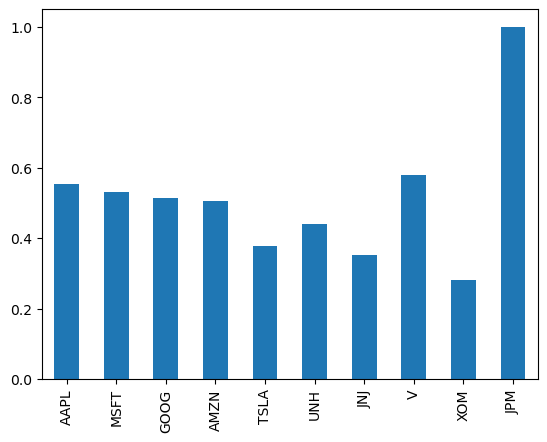

In [68]:
# plot correlation between JP Morgan and the others in top10
mult_df.corr()['JPM'].plot(kind='bar');